# Comparison of terminal state identification

#### Notebook compares metrics for terminal state identification

In [1]:
from tqdm import tqdm

import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
from matplotlib import rcParams
import mplscience

import seaborn as sns
import scvelo as scv
import scanpy as sc
import cellrank as cr

from rgv_tools import DATA_DIR, FIG_DIR
from rgv_tools.plotting._significance import get_significance,add_significance
from rgv_tools.benchmarking import TSI_score,stair_vec

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_t

In [2]:
import pytorch_lightning as pl 
pl.seed_everything(0)

[rank: 0] Global seed set to 0


0

## General setting

In [3]:
DATASET = "zebrafish"

SAVE_FIGURES = False
if SAVE_FIGURES:
    (FIG_DIR / DATASET).mkdir(parents=True, exist_ok=True)

FIGURE_FORMATE = "svg"

In [4]:
plt.rcParams['svg.fonttype'] = 'none'
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=14, color_map='viridis')

## Constants

In [5]:
VELOCITY_METHODS = ["regvelo","scvelo","velovi"]

## Data loading

In [6]:
g_list = {}

for method in VELOCITY_METHODS:
    adata = sc.read_h5ad(DATA_DIR / DATASET / "processed" / f"adata_run_{method}.h5ad")
    ## construct graph
    vk = cr.kernels.VelocityKernel(adata).compute_transition_matrix()
    g_list[method] = vk

100%|██████████| 697/697 [00:00<00:00, 963.59cell/s]


## Terminal state identification

In [7]:
terminal_states = [
        "mNC_head_mesenchymal",
        "mNC_arch2",
        "mNC_hox34",
        "Pigment",
    ]

points = np.linspace(0.1, 1, 21)[:20] ## define threshold from 0.1 to 1
g_rgv = cr.estimators.GPCCA(g_list["regvelo"])
tsi = TSI_score(adata,points,"cell_type",terminal_states,g_rgv)

In [8]:
g_scv = cr.estimators.GPCCA(g_list["scvelo"])
tsi_scv = TSI_score(adata,points,"cell_type",terminal_states,g_scv)

Error: Discretizing leads to a cluster with `3` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
Error: Discretizing leads to a cluster with `4` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
Error: Discretizing leads to a cluster with `3` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
Error: Discretizing leads to a cluster with `4` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
Error: Discretizing leads to a cluster with `3` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
Error: Discretizing leads to a cluster with `4` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
Error: Discretizing leads to a cluster with `3` samples, less than the threshold which is `6` samples. Consider recomputing 

In [9]:
g_vi = cr.estimators.GPCCA(g_list["velovi"])
tsi_vi = TSI_score(adata,points,"cell_type",terminal_states,g_vi)

Error: No macrostates have been selected.
Error: No macrostates have been selected.


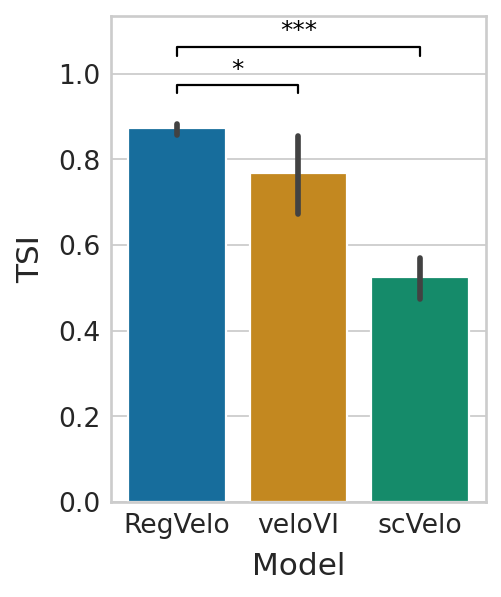

In [10]:
df = pd.DataFrame(
    {
        "TSI":  tsi + tsi_vi + tsi_scv,
        "Model": ["RegVelo"] * 20 + ["veloVI"] * 20 + ["scVelo"] * 20
    }
)        
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(3, 4))

    sns.barplot(data=df, x="Model", y="TSI", palette="colorblind", ax=ax)
    
    ttest_res = ttest_ind(tsi, tsi_vi, alternative="greater")
    significance = get_significance(ttest_res.pvalue)
    add_significance(
        ax=ax, left=0, right=1, significance=significance, lw=1, bracket_level=1.05, c="k", level=0,
    )

    ttest_res = ttest_ind(tsi, tsi_scv, alternative="greater")
    significance = get_significance(ttest_res.pvalue)
    add_significance(
        ax=ax, left=0, right=2, significance=significance, lw=1, c="k", level=2, bracket_level=0.9
    )

    y_min, y_max = ax.get_ylim()
    ax.set_ylim([y_min, y_max + 0.02])
    
    #ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    #ax.set_yticklabels([0.2, 0.4, 0.6, 0.8, 1.0]);
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / DATASET / "TSI_benchmark.svg",
            format="svg",
            transparent=True,
            bbox_inches='tight'
        )
    plt.show()

## Visualize terminal states

In [11]:
pre_value_rgv = stair_vec(adata, g_rgv,0.8,terminal_states,"cell_type")
pre_value_scv = stair_vec(adata, g_scv,0.8,terminal_states,"cell_type")
pre_value_vi = stair_vec(adata, g_vi,0.8,terminal_states,"cell_type")

Error: Discretizing leads to a cluster with `3` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.
Error: Discretizing leads to a cluster with `4` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.


## RegVelo identify all four terminal states

In [12]:
### plot the recovery figure
df = pd.DataFrame({"number_macrostate":range(0,12),
                   "RegVelo":[0]+pre_value_rgv,
                   "veloVI":[0]+pre_value_vi,
                   "scVelo":[0]+pre_value_scv})

In [13]:
df = pd.melt(df, ['number_macrostate'])
colors = sns.color_palette("colorblind", n_colors=3)
colors = colors + [(0.8274509803921568, 0.8274509803921568, 0.8274509803921568)]

/tmp/ipykernel_1237556/3749565524.py:8: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.lineplot(x='number_macrostate', y='value', hue='variable', style='variable', palette=colors, drawstyle='steps-post', data=df, linewidth=3)


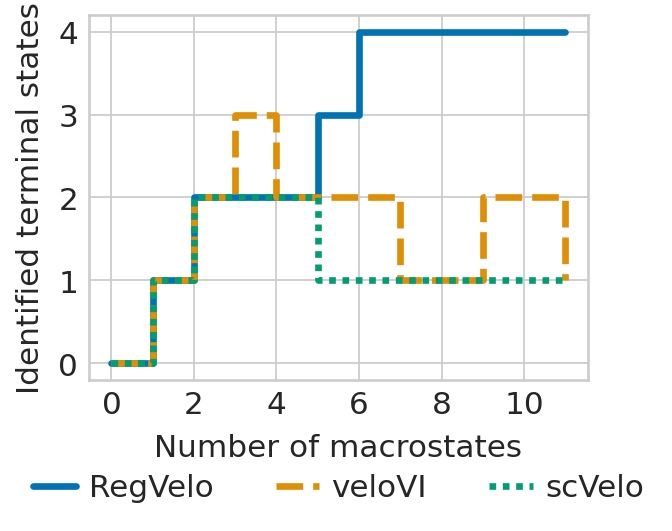

In [14]:
# Set figure size
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    
    rcParams['figure.figsize'] = 4, 3

    # Plot the grid plot
    ax = sns.lineplot(x='number_macrostate', y='value', hue='variable', style='variable', palette=colors, drawstyle='steps-post', data=df, linewidth=3)

    # Set labels and titles
    ax.set(ylabel='Number of correct predictions')
    plt.xlabel('Number of macrostates', fontsize=14)
    plt.ylabel('Identified terminal states', fontsize=14)

    # Customize tick parameters for better readability
    ax.set_xticks([0, 2,4,6,8,10])
    ax.set_xticklabels([0, 2,4,6,8,10]);
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), shadow=True, ncol=4,fontsize = 14)

    if SAVE_FIGURES:
        plt.savefig(
                FIG_DIR / DATASET / "state_identification_update.svg",
                format="svg",
                transparent=True,
                bbox_inches='tight'
            )
    plt.show()